In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn')
sns.set(font_scale=2.5)
import missingno as msno

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
SMALL_SIZE = 20
MEDIUM_SIZE = 25
BIGGER_SIZE = 30

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('legend', fontsize=SMALL_SIZE)

In [3]:
df_train = pd.read_csv("../input/titanic/train.csv")
df_test = pd.read_csv("../input/titanic/test.csv")

In [4]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## Null data check

In [7]:
for col in df_train.columns:
    msg = 'column: {:>10}\t Percent of NaN value: {:.2f}%'.format(col, 100*(df_train[col].isnull().sum() / df_train[col].shape[0]))
    print(msg)

column: PassengerId	 Percent of NaN value: 0.00%
column:   Survived	 Percent of NaN value: 0.00%
column:     Pclass	 Percent of NaN value: 0.00%
column:       Name	 Percent of NaN value: 0.00%
column:        Sex	 Percent of NaN value: 0.00%
column:        Age	 Percent of NaN value: 19.87%
column:      SibSp	 Percent of NaN value: 0.00%
column:      Parch	 Percent of NaN value: 0.00%
column:     Ticket	 Percent of NaN value: 0.00%
column:       Fare	 Percent of NaN value: 0.00%
column:      Cabin	 Percent of NaN value: 77.10%
column:   Embarked	 Percent of NaN value: 0.22%


In [8]:
for col in df_test.columns:
    msg = "column: {:>10}\t Percent of NaN value: {:.2f}%".format(col, 100*(df_test[col].isnull().sum() / df_test[col].shape[0]))
    print(msg)

column: PassengerId	 Percent of NaN value: 0.00%
column:     Pclass	 Percent of NaN value: 0.00%
column:       Name	 Percent of NaN value: 0.00%
column:        Sex	 Percent of NaN value: 0.00%
column:        Age	 Percent of NaN value: 20.57%
column:      SibSp	 Percent of NaN value: 0.00%
column:      Parch	 Percent of NaN value: 0.00%
column:     Ticket	 Percent of NaN value: 0.00%
column:       Fare	 Percent of NaN value: 0.24%
column:      Cabin	 Percent of NaN value: 78.23%
column:   Embarked	 Percent of NaN value: 0.00%


<AxesSubplot:>

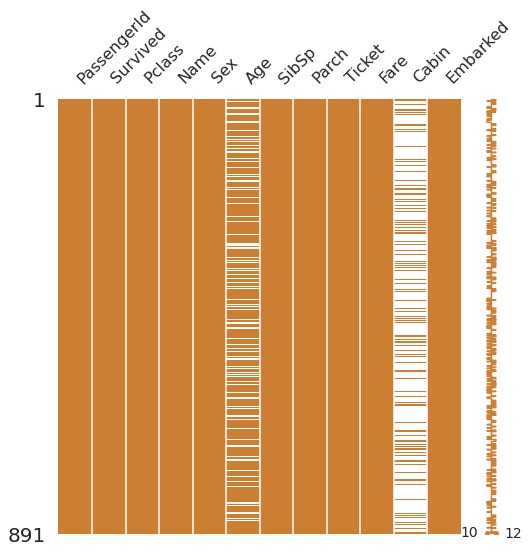

In [9]:
msno.matrix(df=df_train, figsize=(8, 8), color=(0.8, 0.5, 0.2))

<AxesSubplot:>

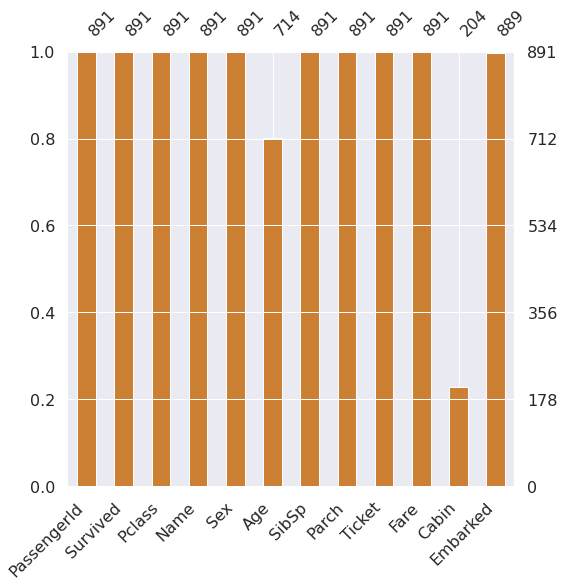

In [10]:
msno.bar(df=df_train, figsize=(8, 8), color=(0.8, 0.5, 0.2))

## Target label 확인

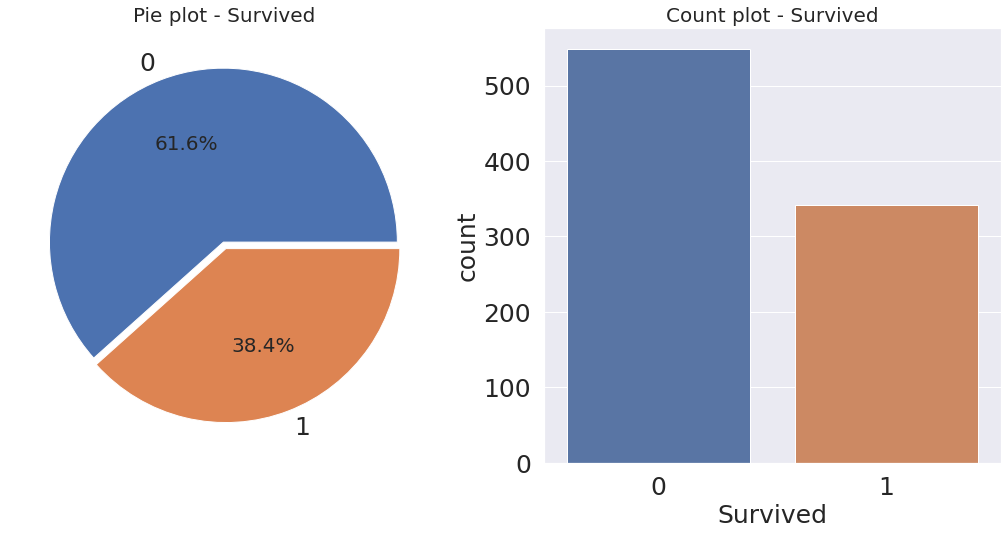

In [11]:
f, ax = plt.subplots(1, 2, figsize=(18, 8))
df_train['Survived'].value_counts().plot.pie(explode=[0.02, 0.02], autopct='%1.1f%%', ax=ax[0])
ax[0].set_title('Pie plot - Survived')
ax[0].set_ylabel("")
sns.countplot('Survived', data=df_train, ax=ax[1])
ax[1].set_title("Count plot - Survived")

plt.show()

# Exploratory data analysis

## Pclass

In [12]:
df_train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=True).count()

,Survived
Pclass,
1,216
2,184
3,491


In [13]:
df_train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=True).sum()

,Survived
Pclass,
1,136
2,87
3,119


In [14]:
pd.crosstab(df_train['Pclass'], df_train['Survived'], margins=True)

Survived,0,1,All
Pclass,,,
1,80,136,216
2,97,87,184
3,372,119,491
All,549,342,891


<AxesSubplot:xlabel='Pclass'>

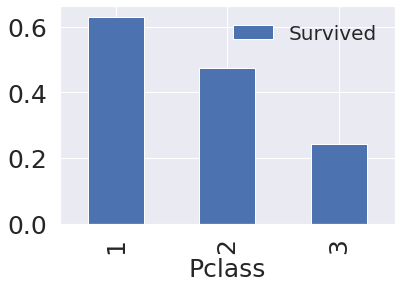

In [15]:
df_train[['Pclass', 'Survived']].groupby('Pclass', as_index=True).mean().sort_values(by='Survived', ascending=False).plot.bar()

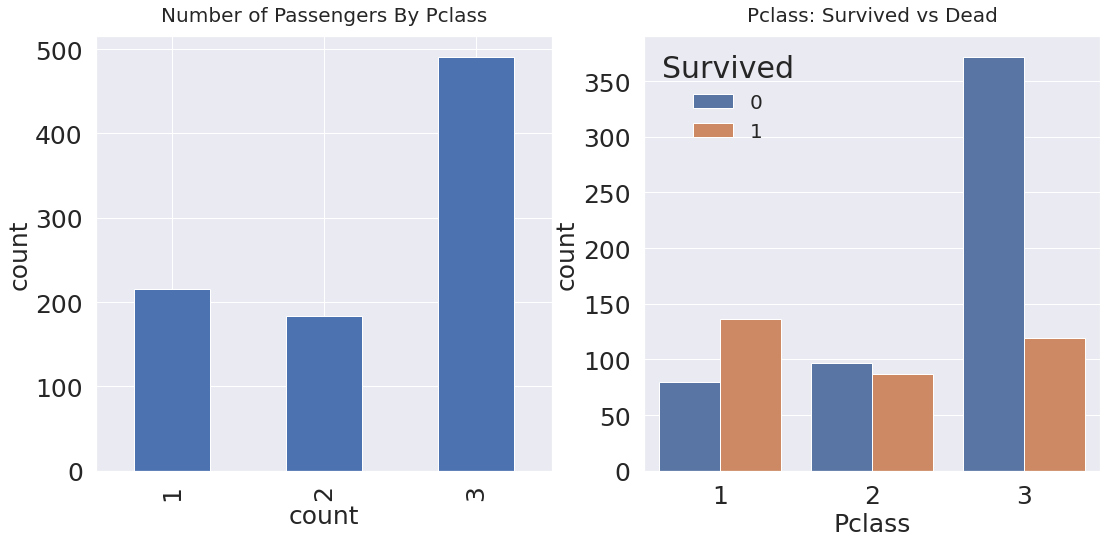

In [16]:
y_position = 1.02
f, ax = plt.subplots(1, 2, figsize=(18, 8))
df_train['Pclass'].value_counts().plot.bar(ax=ax[0])
ax[0].set_title("Number of Passengers By Pclass", y=y_position)
ax[0].set_xlabel('count')
ax[0].set_ylabel('count')

sns.countplot('Pclass', hue='Survived', data=df_train, ax=ax[1])
ax[1].set_title('Pclass: Survived vs Dead', y=y_position)
plt.show()

## Sex

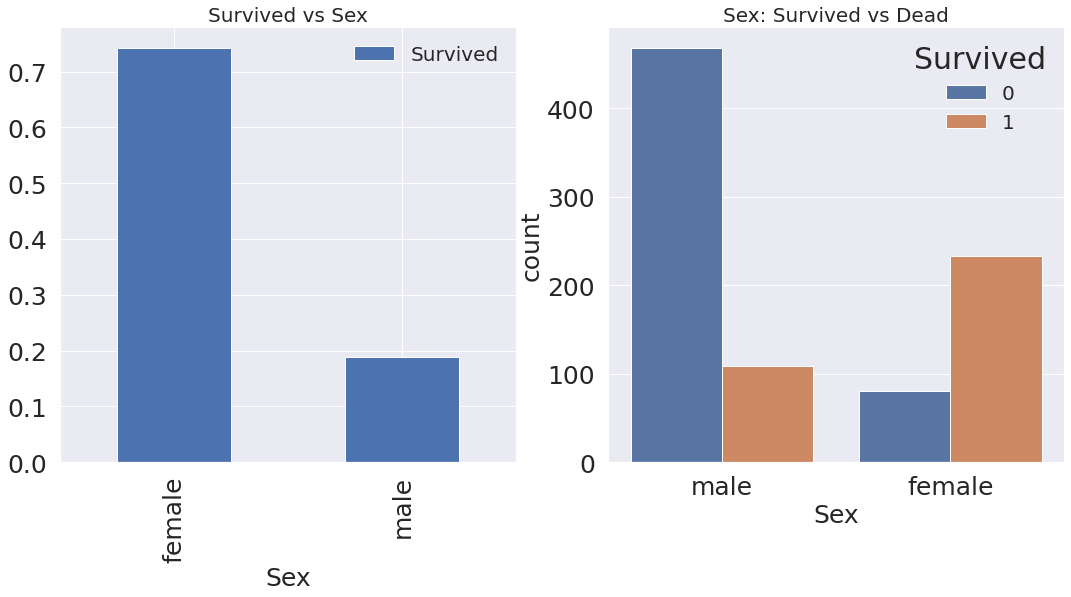

In [17]:
f, ax = plt.subplots(1, 2, figsize=(18, 8))
df_train[['Sex', 'Survived']].groupby('Sex', as_index=True).mean().plot.bar(ax=ax[0])
ax[0].set_title('Survived vs Sex')
sns.countplot('Sex', hue='Survived', data=df_train, ax=ax[1])
ax[1].set_title('Sex: Survived vs Dead')
plt.show()

In [18]:
pd.crosstab(df_train['Sex'], df_train['Survived'], margins=True)

Survived,0,1,All
Sex,,,
female,81,233,314
male,468,109,577
All,549,342,891


## Both Sex and Pclass

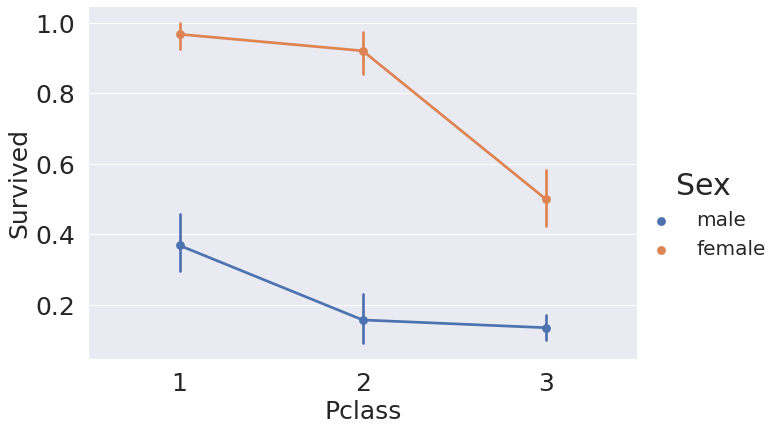

In [19]:
sns.factorplot('Pclass', 'Survived', hue='Sex', data=df_train, size=6, aspect=1.5)

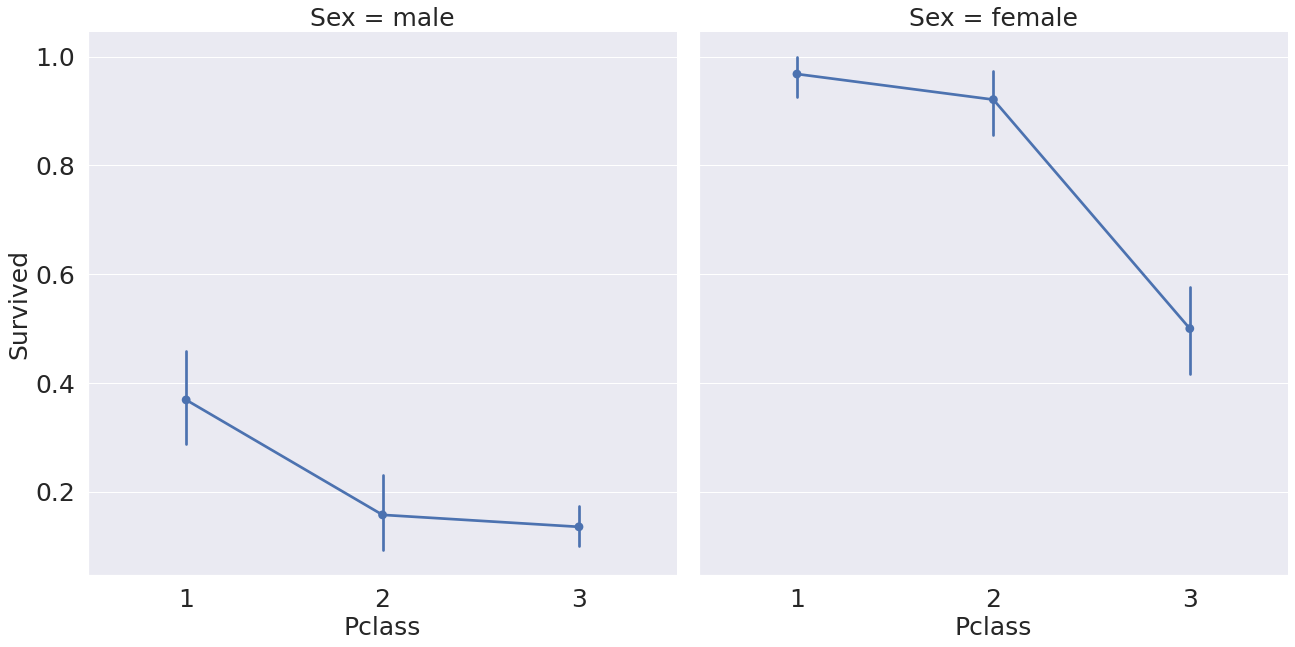

In [20]:
sns.factorplot(x='Pclass', y='Survived', col='Sex', data=df_train, satureation=.5, size=9, aspect=1)

## Age

In [21]:
df_train['Age'].describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

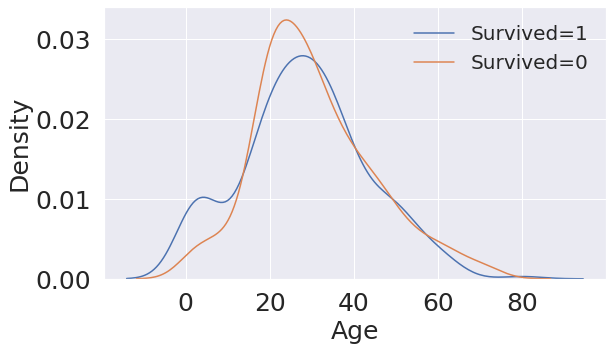

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(9, 5))
sns.kdeplot(df_train[df_train.Survived==1]['Age'], ax=ax)
sns.kdeplot(df_train[df_train.Survived==0]['Age'], ax=ax)
plt.legend(['Survived=1', 'Survived=0'])
plt.show()

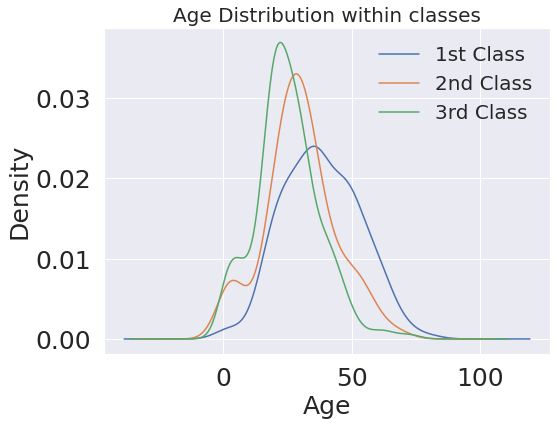

In [23]:
plt.figure(figsize=(8,6))
df_train['Age'][df_train['Pclass'] == 1].plot(kind='kde')
df_train['Age'][df_train['Pclass'] == 2].plot(kind='kde')
df_train['Age'][df_train['Pclass'] == 3].plot(kind='kde')

plt.xlabel('Age')
plt.title('Age Distribution within classes')
plt.legend(['1st Class', '2nd Class', '3rd Class'])

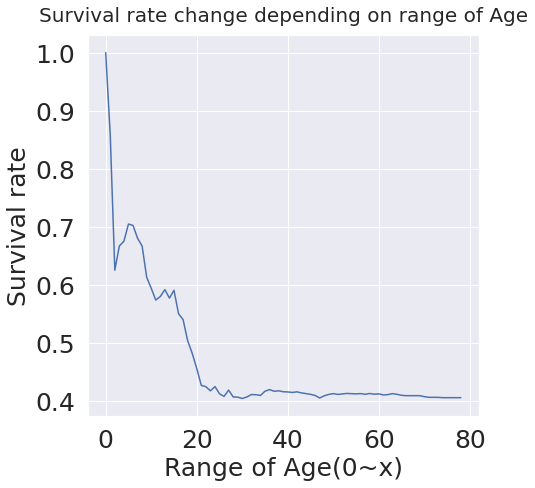

In [24]:
cumulative_survival_ratio = []
for i in range(1, 80):
    cumulative_survival_ratio.append(df_train[df_train['Age'] < i]['Survived'].sum() / df_train[df_train['Age'] < i]['Survived'].count())

plt.figure(figsize=(7, 7))
plt.plot(cumulative_survival_ratio)
plt.title('Survival rate change depending on range of Age', y=1.02)
plt.ylabel('Survival rate')
plt.xlabel('Range of Age(0~x)')
plt.show()

## Pclass, Sex, Age

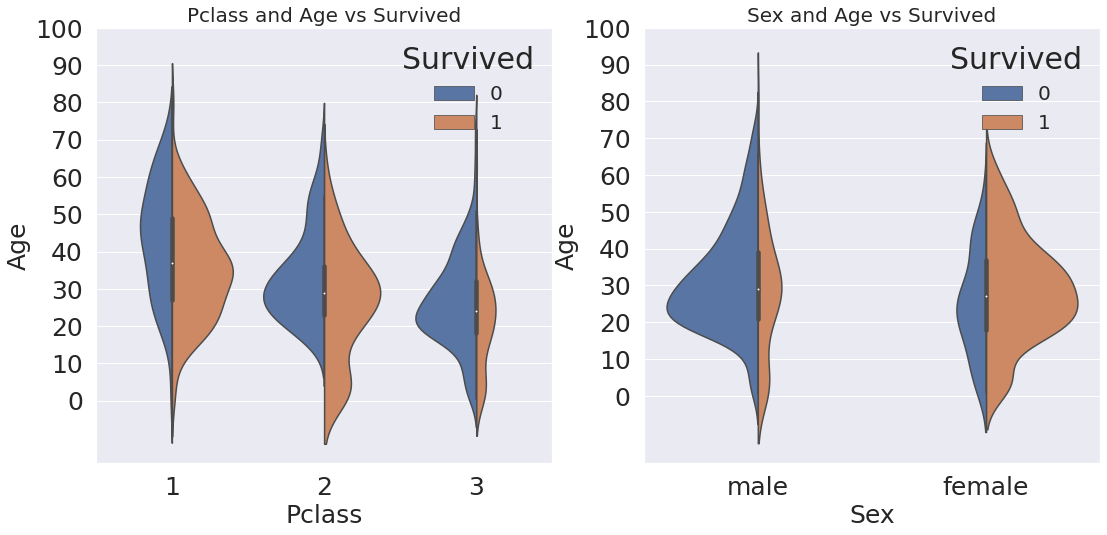

In [25]:
f, ax = plt.subplots(1, 2, figsize=(18, 8))
sns.violinplot('Pclass', 'Age', hue='Survived', data=df_train, scale='count', split=True, ax=ax[0])
ax[0].set_title('Pclass and Age vs Survived')
ax[0].set_yticks(range(0, 110, 10))

sns.violinplot('Sex', 'Age', hue='Survived', data=df_train, scale='count', split=True, ax=ax[1])
ax[1].set_title('Sex and Age vs Survived')
ax[1].set_yticks(range(0, 110, 10))
plt.show()

## Embarked

<AxesSubplot:xlabel='Embarked'>

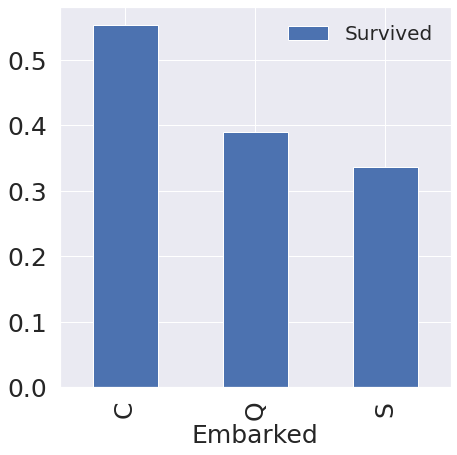

In [26]:
f, ax = plt.subplots(1, 1, figsize=(7, 7))
df_train[['Embarked', 'Survived']].groupby(['Embarked'], as_index=True).mean().sort_values('Survived', ascending=False).plot.bar(ax=ax)

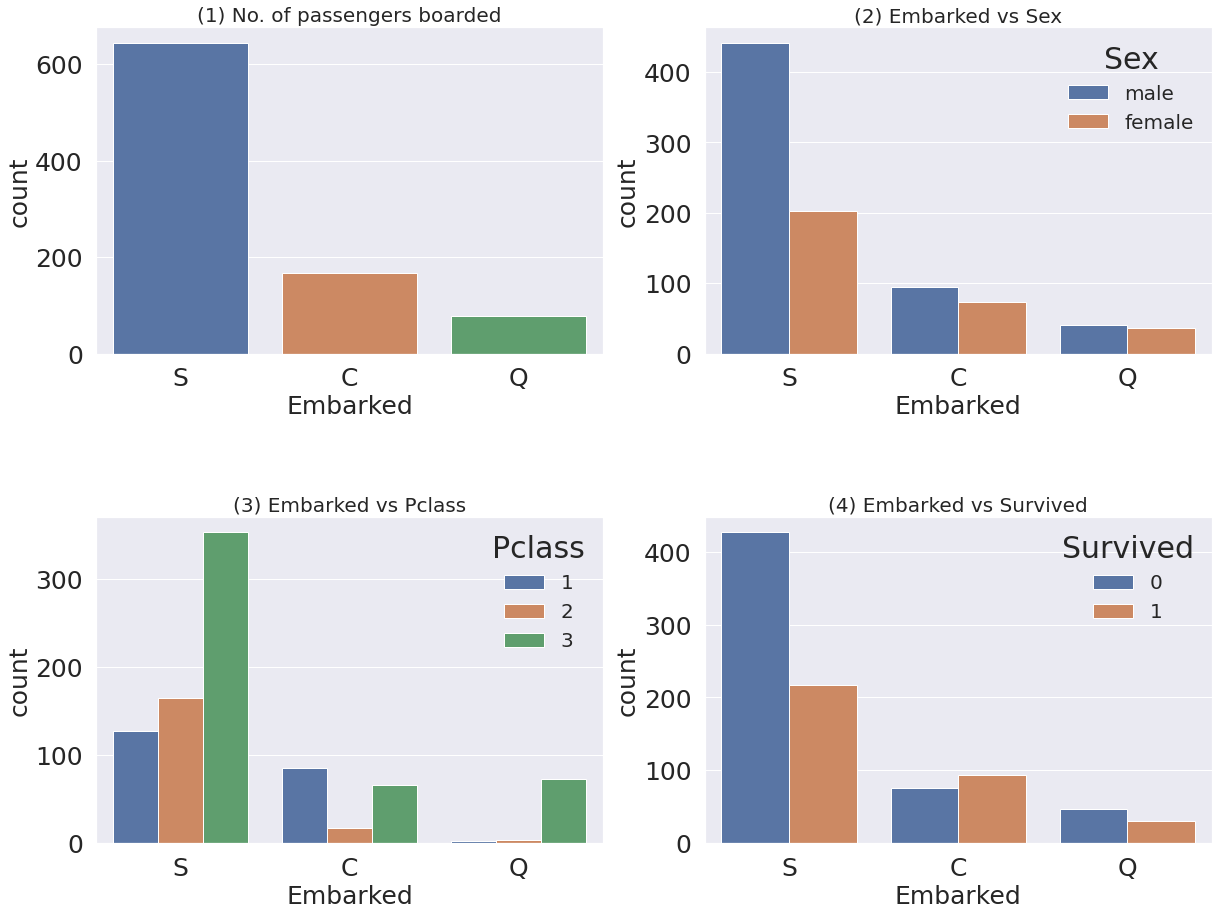

In [27]:
f,ax = plt.subplots(2, 2, figsize=(20, 15))
sns.countplot('Embarked', data=df_train, ax=ax[0,0])
ax[0,0].set_title('(1) No. of passengers boarded')
sns.countplot('Embarked', hue='Sex', data=df_train, ax=ax[0,1])
ax[0,1].set_title('(2) Embarked vs Sex')
sns.countplot('Embarked', hue='Pclass', data=df_train, ax=ax[1,0])
ax[1,0].set_title('(3) Embarked vs Pclass')
sns.countplot('Embarked', hue='Survived', data=df_train, ax=ax[1,1])
ax[1,1].set_title('(4) Embarked vs Survived')
plt.subplots_adjust(wspace=0.2, hspace=0.5)

## Family = SibSp + Parch

In [28]:
df_train['Family'] = df_train['SibSp'] + df_train['Parch'] +1
df_test['Family'] = df_test['SibSp'] + df_test['Parch'] + 1
df_train['Family'].describe()

count    891.000000
mean       1.904602
std        1.613459
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max       11.000000
Name: Family, dtype: float64

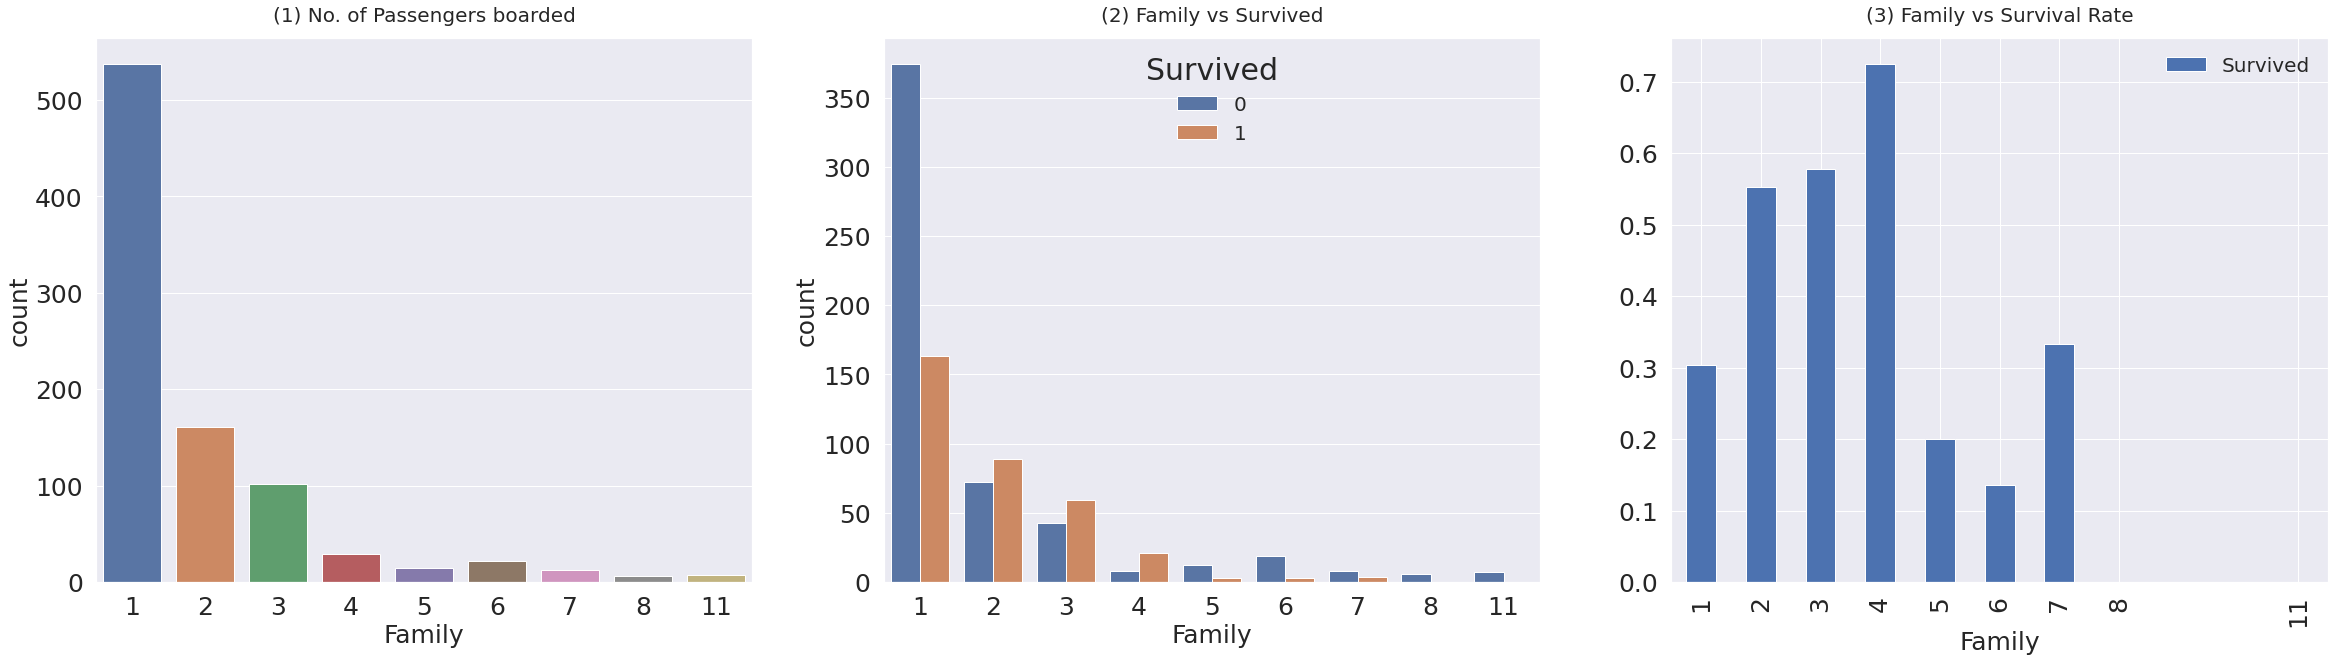

In [29]:
f, ax = plt.subplots(1, 3, figsize=(40, 10))
sns.countplot('Family', data=df_train, ax=ax[0])
ax[0].set_title('(1) No. of Passengers boarded', y=1.02)
sns.countplot('Family', hue='Survived', data=df_train, ax=ax[1])
ax[1].set_title('(2) Family vs Survived', y=1.02)

df_train[['Family', 'Survived']].groupby('Family', as_index=True).mean().sort_values('Survived', ascending=False).plot.bar(ax=ax[2])
ax[2].set_title('(3) Family vs Survival Rate', y=1.02)
plt.show()

## Fare

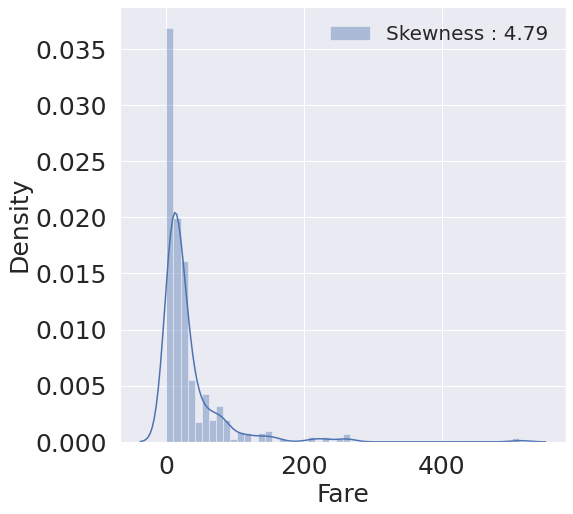

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
g = sns.distplot(df_train['Fare'], label='Skewness : {:.2f}'.format(df_train['Fare'].skew(), ax=ax))
g = g.legend(loc='best')

In [31]:
df_test.loc[df_test.Fare.isnull(), 'Fare'] = df_test['Fare'].mean()
df_train['Fare'] = df_train['Fare'].map(lambda i: np.log(i) if i>0 else 0)
df_test['Fare'] = df_test['Fare'].map(lambda i: np.log(i) if i>0 else 0)

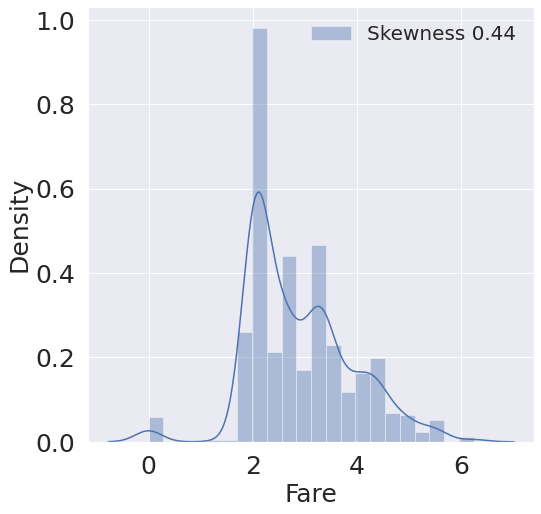

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
g = sns.distplot(df_train.Fare, label="Skewness {:.2f}".format(df_train.Fare.skew()), ax=ax)
g = g.legend(loc='best')

## Cabin
As approx 80% of values are null we exclude this column

In [33]:
df_train['Cabin'].isnull().mean()

0.7710437710437711

## Ticket

In [34]:
df_train['Ticket'].value_counts()

CA. 2343    7
1601        7
347082      7
CA 2144     6
347088      6
           ..
7540        1
3101267     1
363592      1
3474        1
113786      1
Name: Ticket, Length: 681, dtype: int64

In [35]:
fro

NameError: name 'fro' is not defined